# NIH Chest X-ray Dataset

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

## National Institutes of Health Chest X-Ray Dataset

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

### Data limitations:
- 1. The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
 - 2. Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
 - .Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/nih-chest-xrays/data/home <br>
Research paper : http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf <br>
Research paper : https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ <br>
Research paper : https://arxiv.org/pdf/1711.05225.pdf <br>
Blog : https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

- 1. No strict latency constraints.

<h2> 2.1 Data </h2>

### File contents
Image format: 112,120 total images with size 1024 x 1024

**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h

**Data_entry_2017.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y

**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia



### Goal

The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the flow_from_dataframe to deal with messier datasets


In [490]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import FacetGrid
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading </h2>

In [491]:
# reading the data
data = pd.read_csv("dataset/Data_Entry_2017.csv")
data.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [492]:
data.shape

(112120, 12)

In [493]:
data.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

<h2> 3.2 Data cleaning </h2>

In [494]:
#drop unused columns
data = data[['Image Index',"Finding Labels","Follow-up #","Patient ID","Patient Age","Patient Gender"]]

# removing the rows which have patient_age >100
total = len(data)
print('No. of rows before removing rows having age >100 : ',len(data))
data = data[data["Patient Age"]<100]
print('No. of rows after removing rows having age >100 : ',len(data))
print('No. of datapoints having age > 100 : ',total-len(data))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [495]:
# rows having no. of disease
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

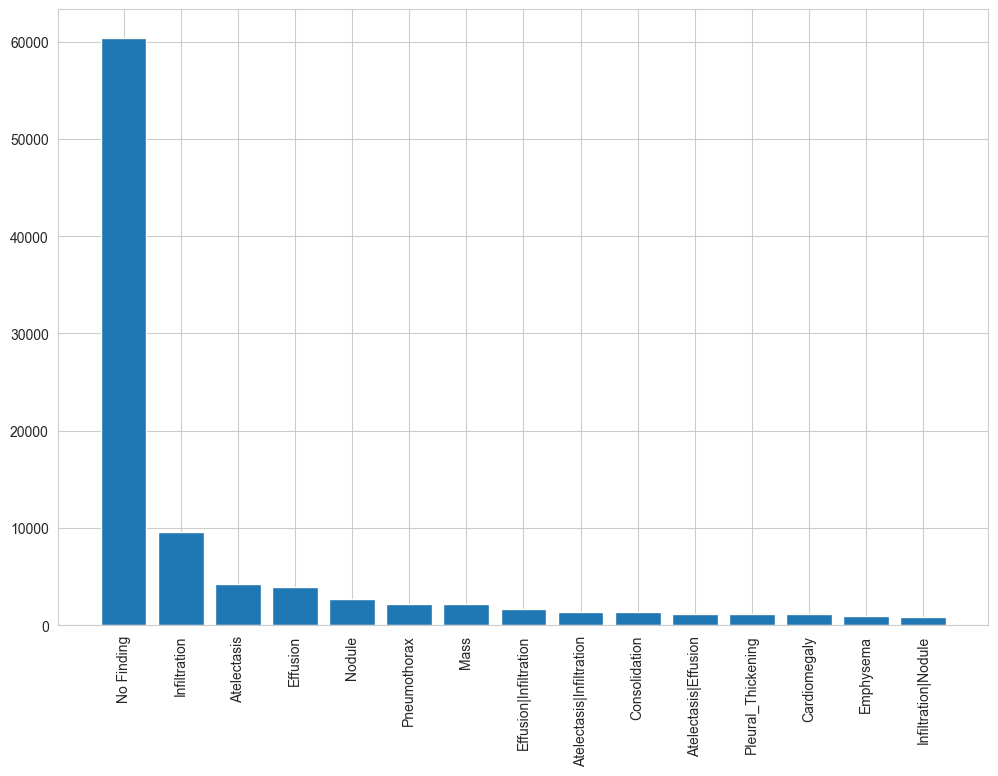

In [496]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

<h2> 3.3 Data analysis </h2>

<h3> 3.3.1 Age distribution </h3>

<Figure size 2000x1500 with 0 Axes>

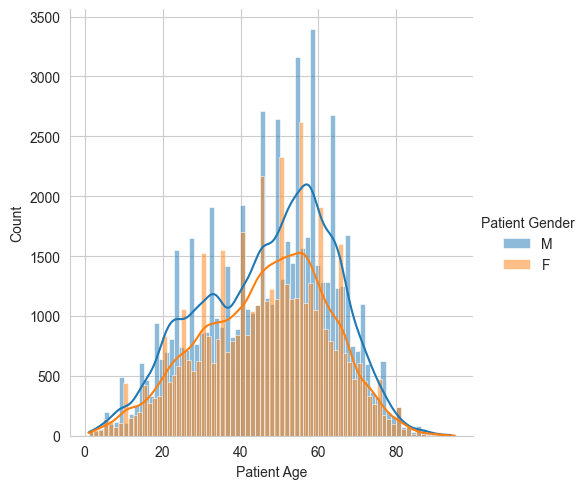

In [497]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(20, 15))
sns.FacetGrid(data, hue='Patient Gender', height=5).map(sns.histplot, 'Patient Age', kde=True).add_legend()
plt.show()


#### Observation - Both the gender have almost same distribution

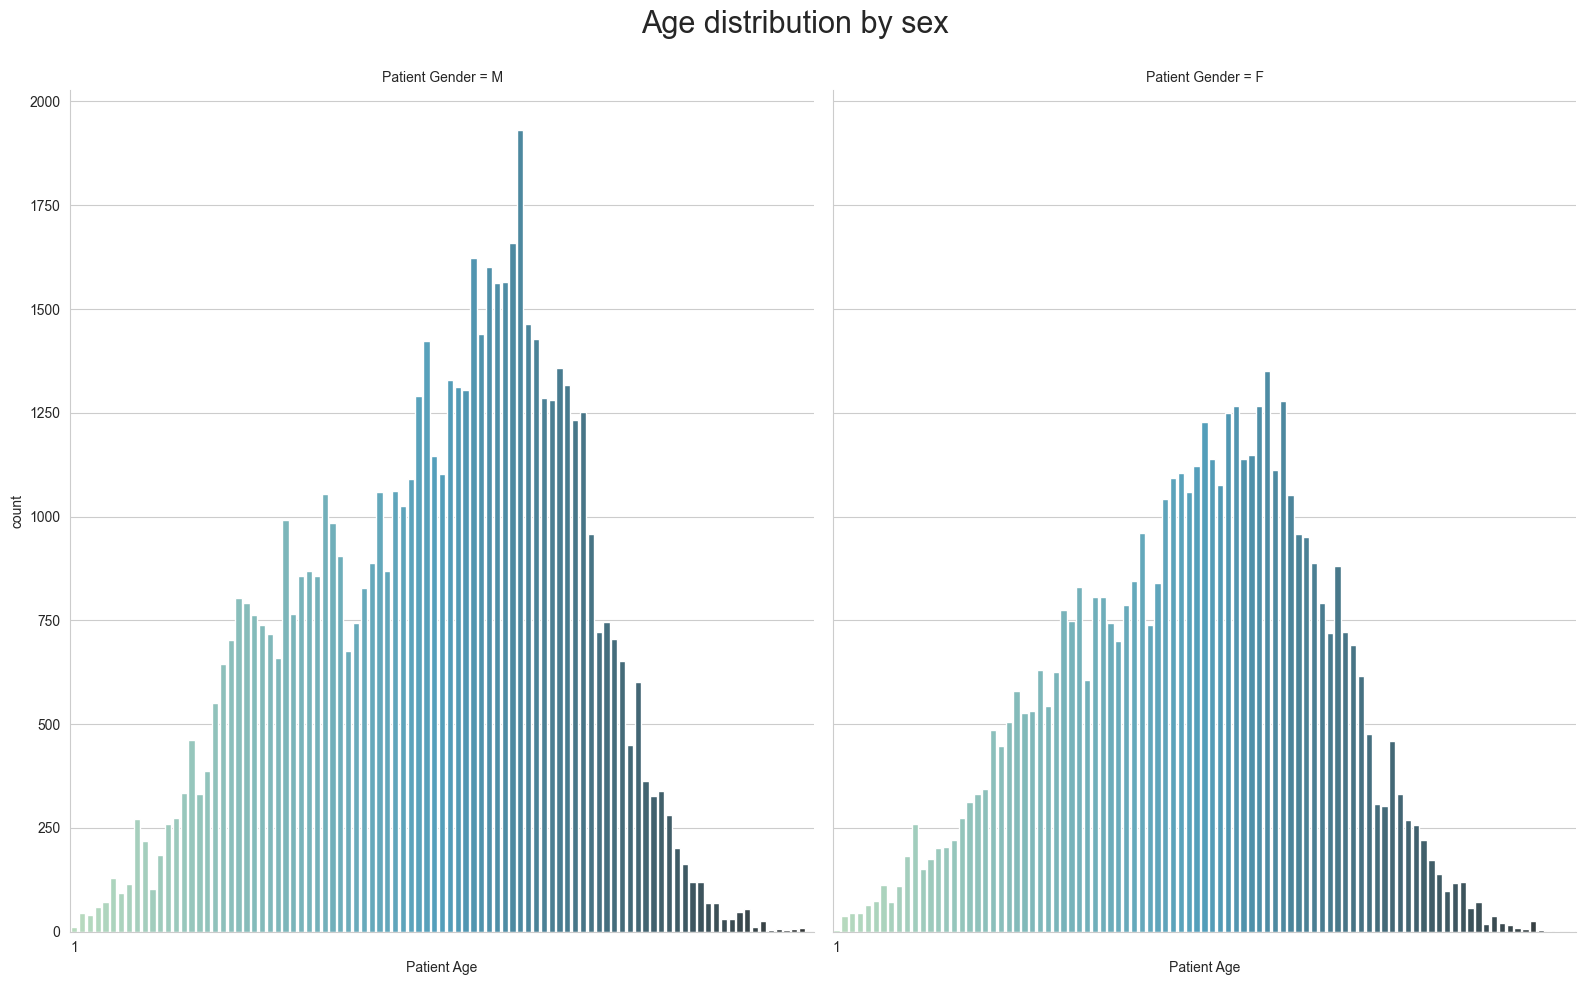

In [498]:
# Create the plot
g = sns.catplot(
    x="Patient Age",
    col="Patient Gender",
    data=data,
    kind="count",
    height=10,  # Replaces size
    aspect=0.8,
    palette="GnBu_d"
)

# Adjust tick labels
g.set_xticklabels(step=10)

# Set the title
g.fig.suptitle('Age distribution by sex', fontsize=22)

# Adjust the layout for the title
g.fig.subplots_adjust(top=0.9)

plt.show()

<h3> 3.3.2 Disease distribution by age and sex </h3>

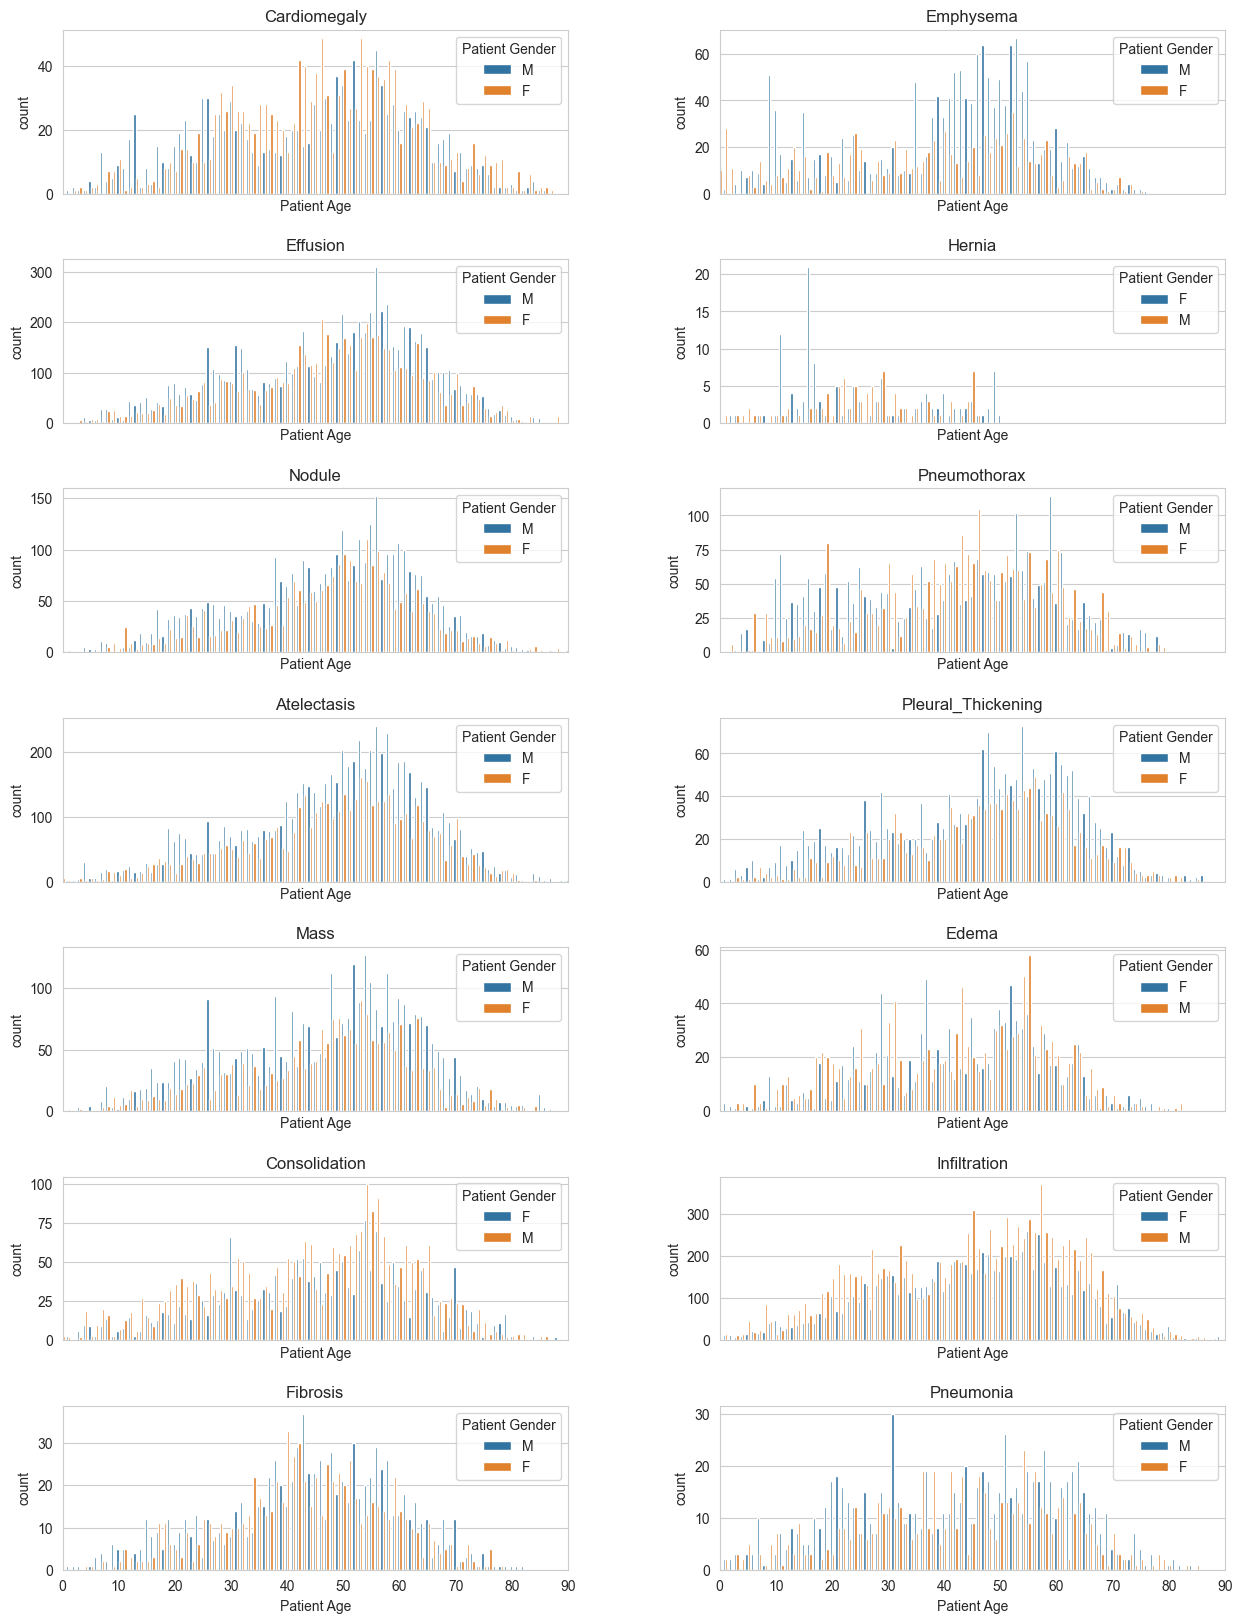

In [499]:
# Prepare the data
f, axarr = plt.subplots(7, 2, sharex=True, figsize=(15, 20))
pathology_list = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 
                  'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 
                  'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']
df = data[data['Finding Labels'] != 'No Finding']

# Define age bins for cleaner plots
age_bins = np.arange(0, 101, 10)
x_ticks = np.arange(0, 100, 10)

# Loop through pathologies and create subplots
i, j = 0, 0
for pathology in pathology_list:
    # Filter rows containing the current pathology
    pathology_df = df[df['Finding Labels'].str.contains(pathology, na=False)]
    
    # Ensure there's data to plot
    if not pathology_df.empty:
        g = sns.countplot(
            x='Patient Age', hue="Patient Gender", data=pathology_df, ax=axarr[i, j]
        )
        axarr[i, j].set_title(pathology)
        axarr[i, j].set_xlim(0, 90)
        axarr[i, j].set_xticks(x_ticks)
        axarr[i, j].set_xticklabels(x_ticks)
    else:
        axarr[i, j].set_title(f"{pathology} (No Data)")
        axarr[i, j].axis("off")  # Hide axes if no data

    # Update subplot indices
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 7

# Adjust subplot layout
f.subplots_adjust(hspace=0.4, wspace=0.3)

# Show the plots
plt.show()

<h3> 3.3.3 No. of each disease by patient gender </h3>

In [500]:
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

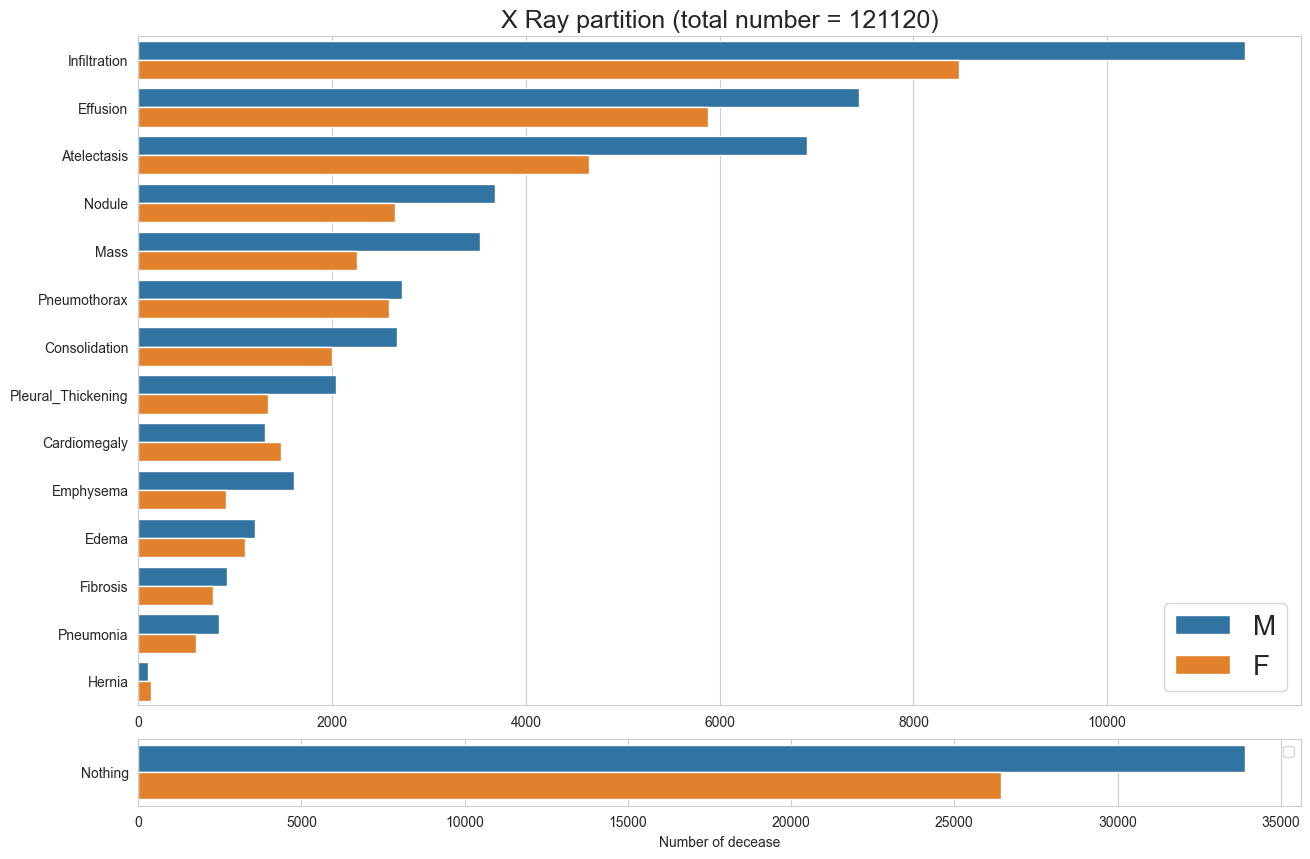

In [501]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

<h3> 3.3.4 Display patient number by Follow-up in details </h3>

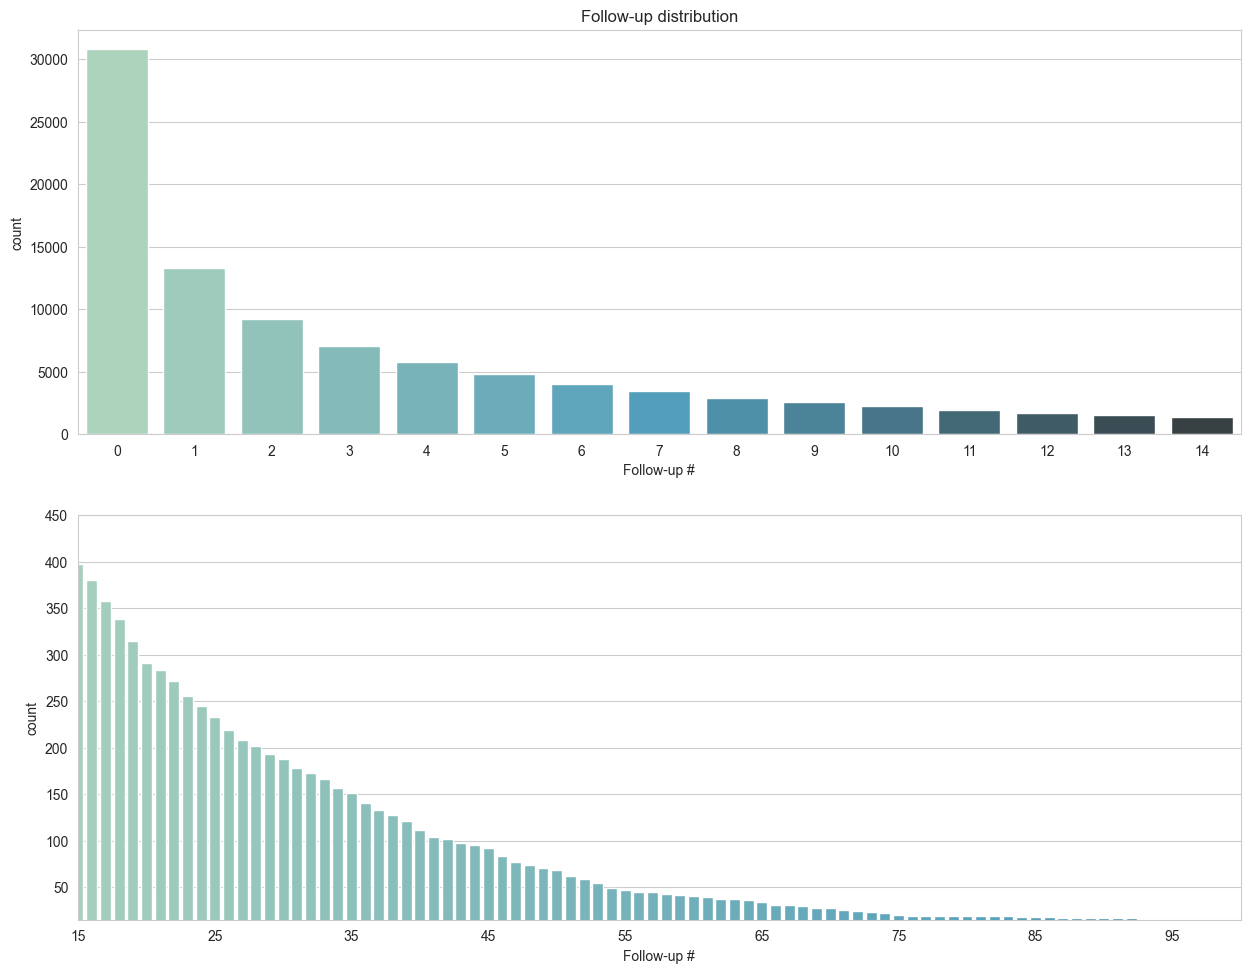

In [502]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

df = data[data['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax1);

ax1.set_title('Follow-up distribution');
df = data[data['Follow-up #']>14]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

<h3> 3.3.5 ratio between one and multiple disease </h3>

In [503]:
df=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

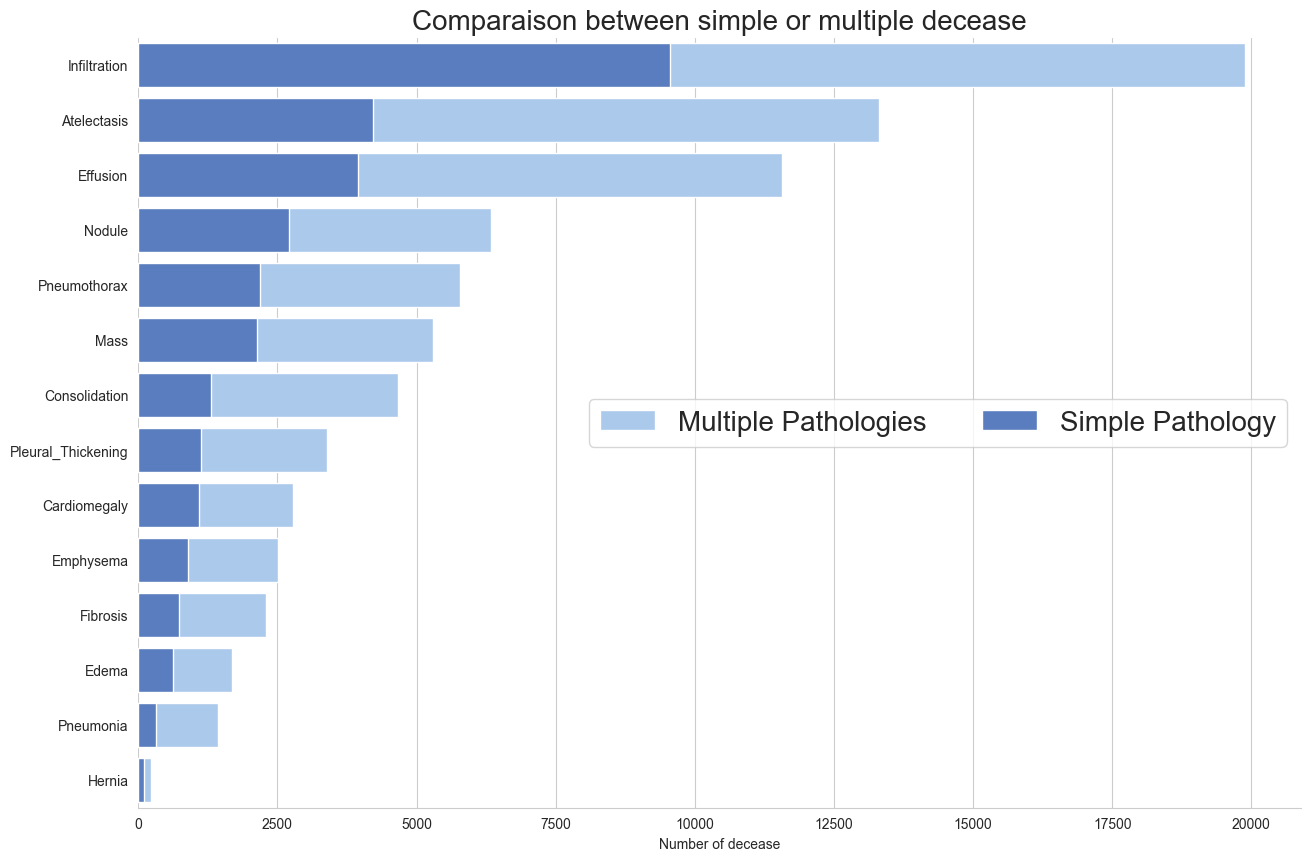

In [504]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

<h3> 3.3.6 Plot most important pathologies groups for each desease </h3>

In [505]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   
Cardiomegaly|Effusion                     484   
Consolidation|Infiltration                441   
Infiltration|Mass                         418   
Effusion|Pneumothorax                     403   
Effusion|Mass                             402   
Atelectasis|Consolidation                 398   
Mass|Nodule                               394   
Edema|Infiltration                        392   
Infiltration|Pneumothorax                 345   
Consolidation|Effusion                    337   
Emphysema|Pneumothorax                    337   
Effusion|Pleural_Thickening               251   
Effusion|Nodule                           249   
Atelectasis|Pneumothorax                  240   
Infiltration|Pleural_Thickening           210   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   
Cardiomegaly|Effusion                          Cardiomegaly|Effusion   
Consolidation|Infiltration                Consolidation|Infiltration   
Infiltration|Mass                                  Infiltration|Mass   
Effusion|Pneumothorax                          Effusion|Pneumothorax   
Effusion|Mass                                          Effusion|Mass   
Atelectasis|Consolidation                  Atelectasis|Consolidation   
Mass|Nodule                                              Mass|Nodule   
Edema|Infiltration                                Edema|Infiltration   
Infiltration|Pneumothorax                  Infiltration|Pneumothorax   
Consolidation|Effusion                        Consolidation|Effusion   
Emphysema|Pneumothorax                        Emphysema|Pneumothorax   
Effusion|Pleural_Thickening              Effusion|Pleural_Thickening   
Effusion|Nodule                                      Effusion|Nodule   
Atelectasis|Pneumothorax                    Atelectasis|Pneumothorax   
Infiltration|Pleural_Thickening      Infiltration|Pleural_Thickening   

                                   Cardiomegaly  Emphysema  Effusion  Hernia  \
Finding Labels                                                                 
Effusion|Infiltration                         0          0      1603       0   
Atelectasis|Infiltration                      0          0         0       0   
Atelectasis|Effusion                          0          0      1165       0   
Infiltration|Nodule                           0          0         0       0   
Atelectasis|Effusion|Infiltration             0          0       737       0   
Cardiomegaly|Effusion                       484          0       484       0   
Consolidation|Infiltration                    0          0         0       0   
Infiltration|Mass                             0          0         0       0   
Effusion|Pneumothorax                         0          0       403       0   
Effusion|Mass                                 0          0       402       0   
Atelectasis|Consolidation                     0          0         0       0   
Mass|Nodule                                   0          0         0       0   
Edema|Infiltration                            0          0         0       0   
Infiltration|Pneumothorax                     0          0         0       0   
Consolidation|Effusion                        0          0       337       0   
Emphysema|P

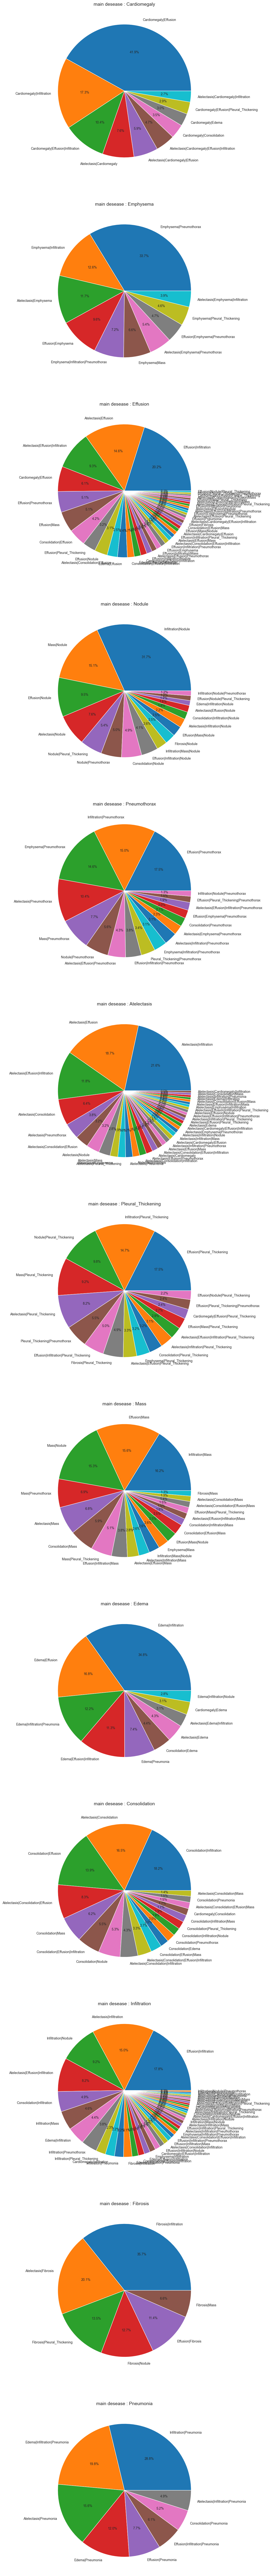

In [506]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1


<h1> 4. Creating data for model </h1>

In [507]:
data = pd.read_csv('dataset/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 0 , Total Headers 112104


Image Index            Finding Labels  Follow-up #  Patient ID  \
1451   00000376_008.png    Atelectasis|Edema|Mass            8         376   
14325  00003719_000.png                No Finding            0        3719   
60624  00014958_009.png  Atelectasis|Infiltration            9       14958   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
1451            49              M            AP                 2500     2048   
14325           50              F            PA                 2500     2048   
60624           19              F            AP                 2500     2048   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  path  
1451                         0.168  0.168          NaN  None  
14325                        0.168  0.168          NaN  None  
60624                        0.168  0.168          NaN  None

In [508]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
21752  00005773_004.png       Effusion            4        5773           35   
14985  00003923_000.png    Atelectasis            0        3923           26   
15772  00004163_002.png                           2        4163           49   

      Patient Gender View Position  OriginalImage[Width  Height]  \
21752              F            AP                 2500     2048   
14985              M            PA                 2048     2500   
15772              M            PA                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Effusion  Emphysema Fibrosis  Hernia  \
21752                        0.171  ...       1.0        0.0      0.0     0.0   
14985                        0.171  ...       0.0        0.0      0.0     0.0   
15772                        0.171  ...       0.0        0.0      0.0     0.0   

       Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
21752           0.0   0.0     0.0                 0.0        0.0           0.0  
14985           0.0   0.0     0.0                 0.0        0.0           0.0  
15772           0.0   0.0     0.0                 0.0        0.0           0.0  

[3 rows x 27 columns]

In [509]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


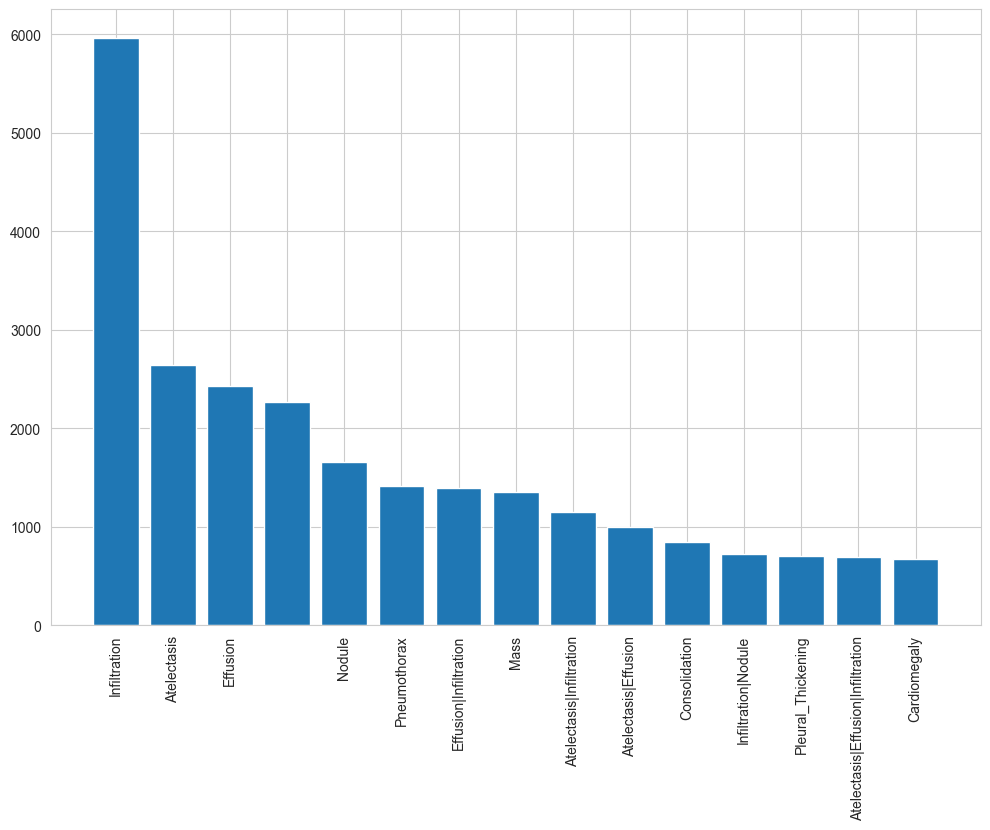

In [510]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [511]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [512]:
data.iloc[0]['disease_vec']

array([1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)

In [513]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, 
                                   test_size = 0.25, 
                                   random_state = 2024,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])
print(train_df["Image Index"])

train 30000 validation 10000
48073    00012175_009.png
62268    00015401_027.png
88102    00021795_001.png
52453    00013244_009.png
18478    00004909_006.png
               ...       
32343    00008468_017.png
29548    00007684_002.png
65       00000013_027.png
54438    00013659_020.png
16332    00004353_000.png
Name: Image Index, Length: 30000, dtype: object


In [514]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [515]:
def custom_flow_from_dataframe(img_data_gen, in_df, path_col, y_col, batch_size, target_size, color_mode):
    """
    Custom generator that directly uses a DataFrame without relying on `flow_from_directory`.
    Ensures that labels are properly formatted as numpy arrays with float32 dtype.
    """
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # Ensure valid paths
    valid_df = in_df[in_df[path_col].apply(os.path.exists)].reset_index(drop=True)
    
    if valid_df.empty:
        raise ValueError("No valid image paths found in the DataFrame!")

    # Preprocess the labels column to ensure proper dtype
    valid_df[y_col] = valid_df[y_col].apply(lambda x: np.array(x, dtype='float32'))

    # Generator function
    def generator():
        while True:
            for start in range(0, len(valid_df), batch_size):
                end = min(start + batch_size, len(valid_df))
                batch_df = valid_df.iloc[start:end]

                # Load images and labels
                images = []
                labels = []
                for _, row in batch_df.iterrows():
                    img = load_img(
                        row[path_col],
                        target_size=target_size,
                        color_mode=color_mode
                    )
                    images.append(img_to_array(img))  # Convert image to array
                    labels.append(row[y_col])  # Already preprocessed as float32

                # Normalize images to [0, 1]
                images = np.array(images) / 255.0
                yield np.array(images, dtype='float32'), np.array(labels, dtype='float32')

    return generator(), len(valid_df)


In [516]:
import os

# Define the base directory
base_dir = 'dataset/images-224/images-224'

# Normalize paths in 'Image Index' column
train_df["Image Index"] = train_df["Image Index"].apply(lambda x: os.path.normpath(x))
valid_df["Image Index"] = valid_df["Image Index"].apply(lambda x: os.path.normpath(x))

# If 'Image Index' only contains filenames, rebuild correct paths
if not train_df["Image Index"].iloc[0].startswith(base_dir):
    train_df["Image Index"] = train_df["Image Index"].apply(lambda x: os.path.join(base_dir, os.path.basename(x)))
    valid_df["Image Index"] = valid_df["Image Index"].apply(lambda x: os.path.join(base_dir, os.path.basename(x)))

# Verify paths
print(train_df["Image Index"].head())
assert all(train_df["Image Index"].apply(os.path.exists)), "Some train paths do not exist!"
assert all(valid_df["Image Index"].apply(os.path.exists)), "Some valid paths do not exist!"

# Proceed with your generator
# Initialize the training generator
train_gen, train_steps = custom_flow_from_dataframe(
    img_data_gen=core_idg, 
    in_df=train_df,
    path_col="Image Index", 
    y_col="disease_vec", 
    batch_size=32, 
    target_size=(128, 128), 
    color_mode="grayscale"
)

# Validation generator (optional)
valid_gen, valid_steps = custom_flow_from_dataframe(
    img_data_gen=core_idg, 
    in_df=valid_df,
    path_col="Image Index", 
    y_col="disease_vec", 
    batch_size=32, 
    target_size=(128, 128), 
    color_mode="grayscale"
)


# Fetch a batch for testing
test_X, test_Y = next(train_gen)
print(f"x_batch dtype: {x_batch.dtype}, shape: {x_batch.shape}")
print(f"y_batch dtype: {y_batch.dtype}, shape: {y_batch.shape}")


48073    dataset/images-224/images-224\00012175_009.png
62268    dataset/images-224/images-224\00015401_027.png
88102    dataset/images-224/images-224\00021795_001.png
52453    dataset/images-224/images-224\00013244_009.png
18478    dataset/images-224/images-224\00004909_006.png
Name: Image Index, dtype: object
x_batch dtype: float32, shape: (32, 128, 128, 1)
y_batch dtype: float32, shape: (32, 13)


Pixel range: Min = 0.0 , Max = 1.0


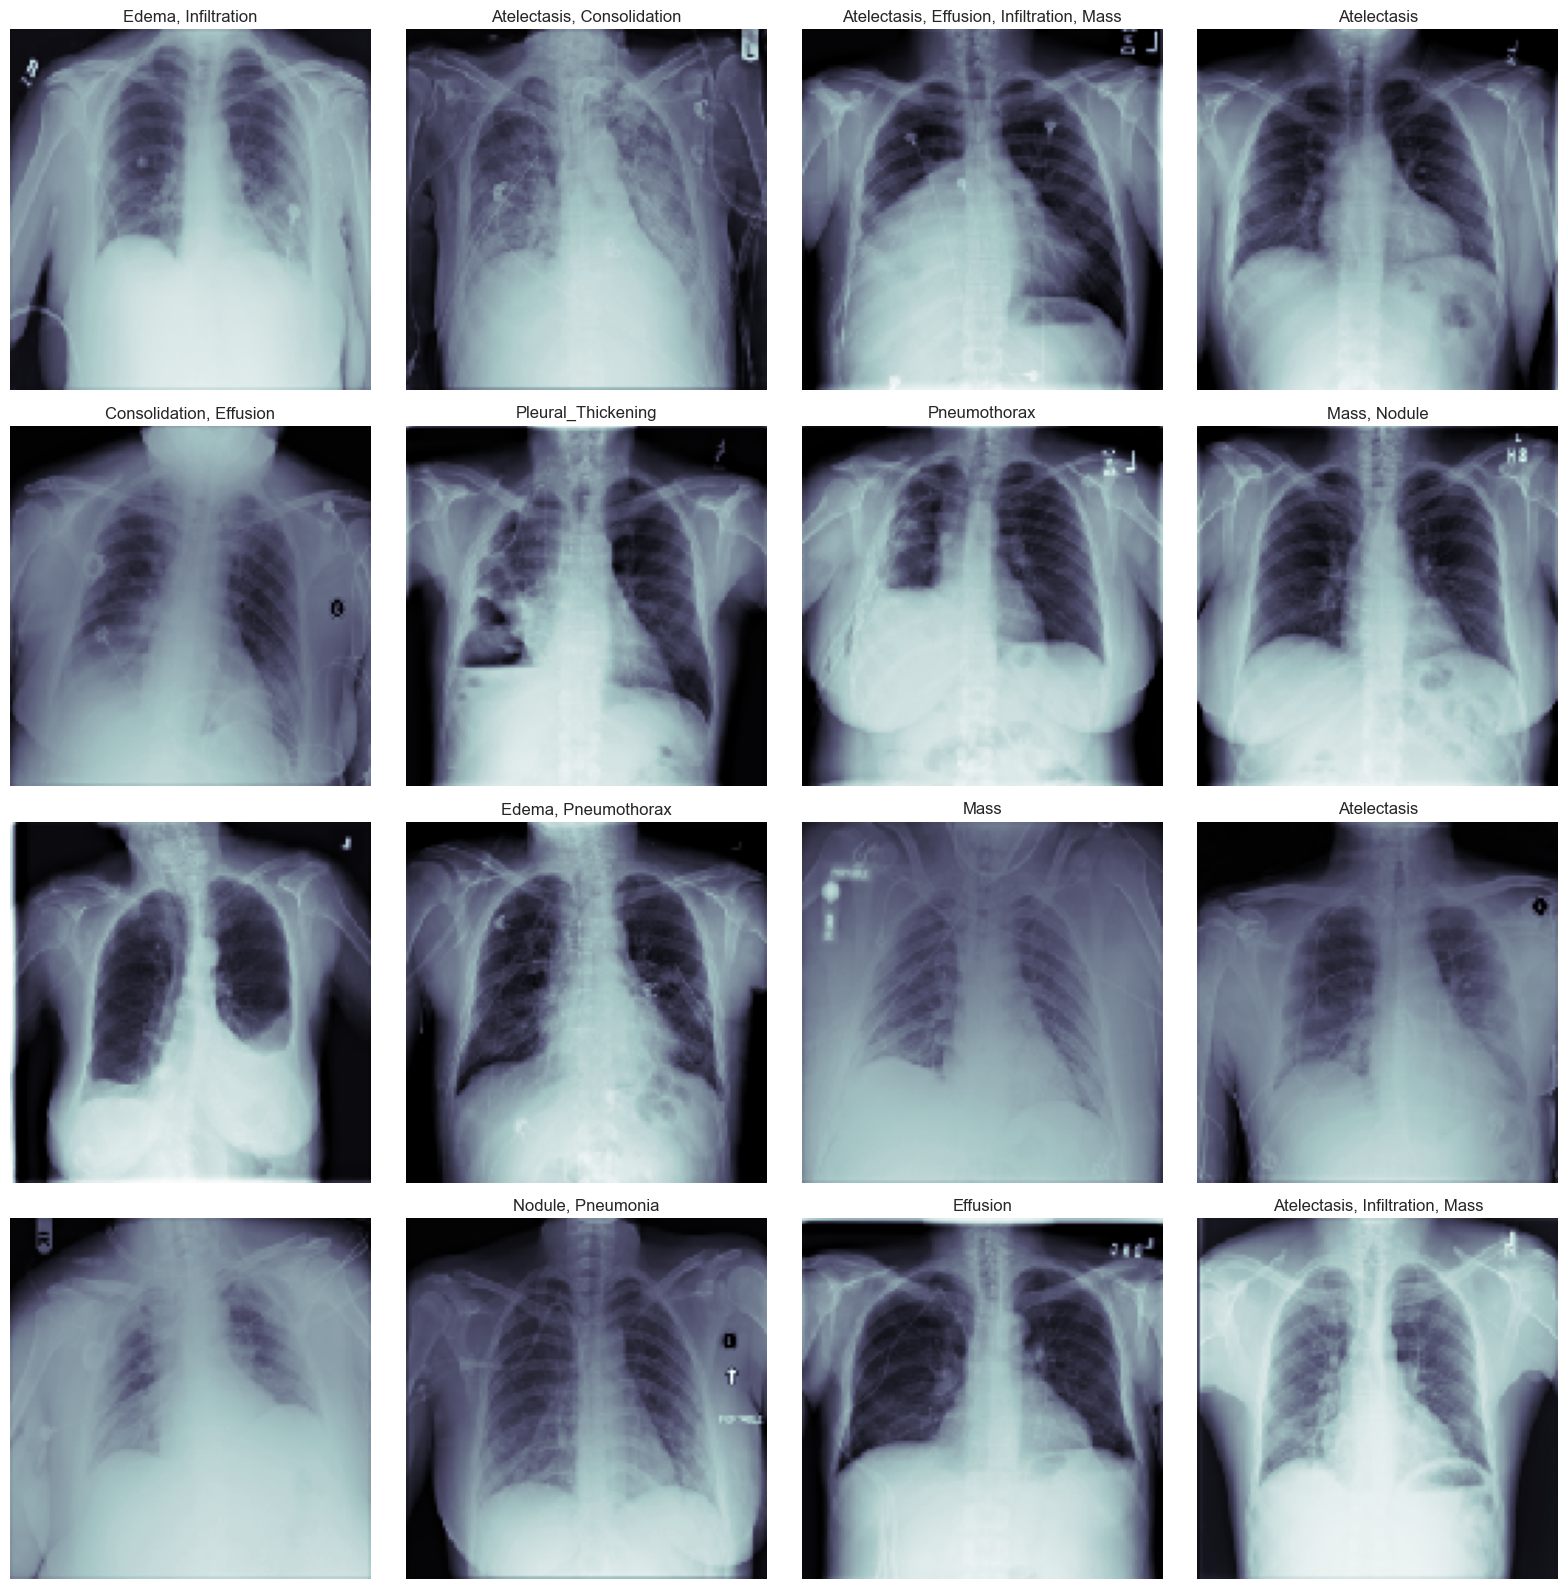

In [517]:
t_x, t_y = next(train_gen)

# Check the pixel value range
print("Pixel range: Min =", t_x.min(), ", Max =", t_x.max())

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    # Adjust vmin and vmax dynamically
    c_ax.imshow(c_x[:, :, 0], cmap='bone', vmin=t_x.min(), vmax=t_x.max())
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score > 0.5]))
    c_ax.axis('off')
plt.tight_layout()
plt.show()


### Create a simple model

Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features


In [518]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,759,757 (14.34 MB)

 Trainable params: 3,737,869 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [519]:
print(train_df['disease_vec'].dtype)
print(train_df['disease_vec'].head())

# Convert each list in 'disease_vec' to a numpy array with dtype float32
train_df['disease_vec'] = train_df['disease_vec'].apply(lambda x: np.array(x, dtype='float32'))



object
48073    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
62268    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
88102    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
52453    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
18478    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
Name: disease_vec, dtype: object


In [520]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Correct the weight path
weight_path = "{}_weights.best.weights.h5".format('xray_class')

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only=True)

# Define the EarlyStopping callback
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)

# Combine callbacks
callbacks_list = [checkpoint, early]


### First Round

Here we do a first round of training to get a few initial low hanging fruit results


In [521]:
# Correct the weight path
weight_path = "{}_weights.best.weights.h5".format('xray_class')

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only=True)

# Other callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callbacks_list = [checkpoint, early]


In [522]:
multi_disease_model.fit(train_gen,
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8361 - loss: 0.5041 - mae: 0.2090
Epoch 1: val_loss improved from inf to 0.35247, saving model to xray_class_weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - binary_accuracy: 0.8362 - loss: 0.5036 - mae: 0.2089 - val_binary_accuracy: 0.8750 - val_loss: 0.3525 - val_mae: 0.2521
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8663 - loss: 0.3940 - mae: 0.1993
Epoch 2: val_loss did not improve from 0.35247
100/100 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - binary_accuracy: 0.8663 - loss: 0.3939 - mae: 0.1993 - val_binary_accuracy: 0.8750 - val_loss: 0.3555 - val_mae: 0.1521
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8664 - loss: 0.3692 - mae: 0.1990
Epoch 3: val_loss did not improve from 0.35247
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - binary_accuracy: 0.8664 - loss: 0.3691 - mae: 0.1990 - val_binary_accuracy: 0.8750 - val_loss: 0.3860 - val_mae: 0.14

### Check Output

Here we see how many positive examples we have of each category


GRAD-CAM

In [523]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates Grad-CAM heatmap for a given image and model.
    
    Args:
        img_array: Preprocessed image array (batch of 1).
        model: Trained CNN model.
        last_conv_layer_name: Name of the last convolutional layer in the model.
        pred_index: Index of the prediction to visualize (default: top prediction).

    Returns:
        Heatmap highlighting important regions for the prediction.
    """
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of the predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Average gradients spatially
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


In [524]:
def overlay_heatmap(heatmap, original_image, alpha=0.4):
    """
    Overlays heatmap on the original image.

    Args:
        heatmap: Grad-CAM heatmap (2D array).
        original_image: Original X-ray image (2D or 3D array).
        alpha: Transparency factor for heatmap overlay.

    Returns:
        Overlayed image with heatmap.
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlayed_img = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


In [525]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 21.88%
Cardiomegaly: 9.38%
Consolidation: 6.25%
Edema: 0.00%
Effusion: 40.62%
Emphysema: 3.12%
Fibrosis: 3.12%
Infiltration: 34.38%
Mass: 6.25%
Nodule: 12.50%
Pleural_Thickening: 9.38%
Pneumonia: 0.00%
Pneumothorax: 15.62%


In [526]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


### ROC Curves

While a very oversimplified metric, we can show the ROC curve for each metric


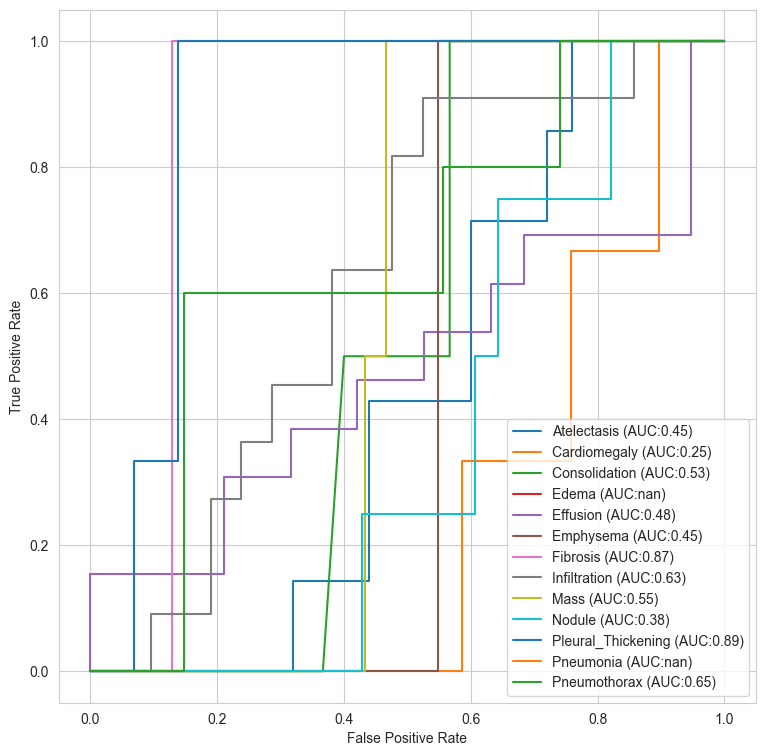

In [527]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

### Continued Training

Now we do a much longer training process to see how the results improve


In [ ]:
multi_disease_model.fit(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

# Save the entire model to a file



Epoch 1/5
 24/100 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - binary_accuracy: 0.8728 - loss: 0.3409 - mae: 0.1947

In [ ]:
multi_disease_model.save("model_weights.h5")
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)
multi_disease_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,235,497 (42.86 MB)

 Trainable params: 3,737,869 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 7,475,740 (28.52 MB)

In [ ]:
# Run predictions with the trained model
pred_Y = multi_disease_model.predict(test_X, batch_size=32, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


In [ ]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Cardiomegaly: Dx: 34.38%, PDx: 27.54%
Pneumonia: Dx: 3.12%, PDx: 5.76%
Pneumothorax: Dx: 6.25%, PDx: 11.12%
Tuberculosis: Dx: 6.25%, PDx: 5.86%


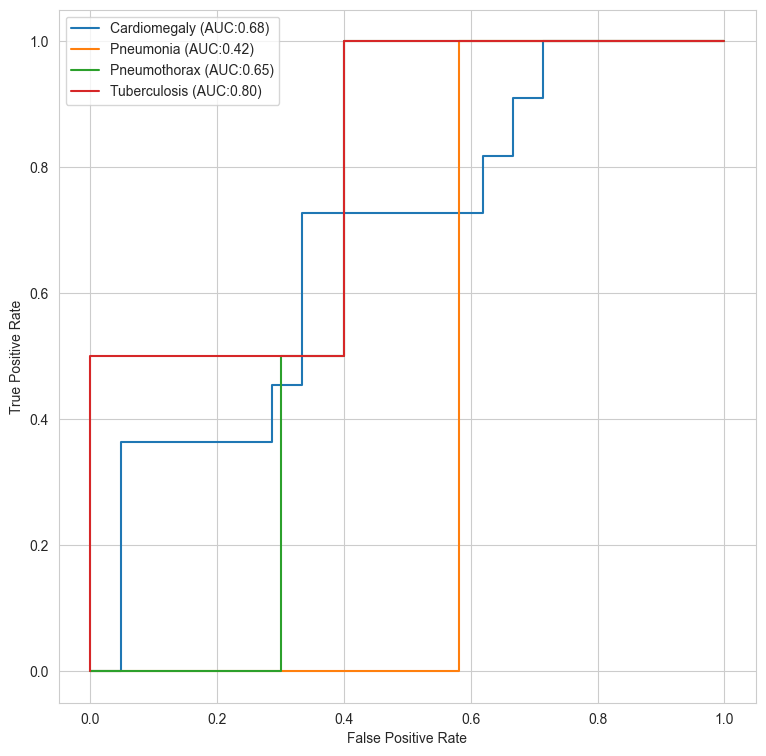

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

### Show a few images and associated predictions

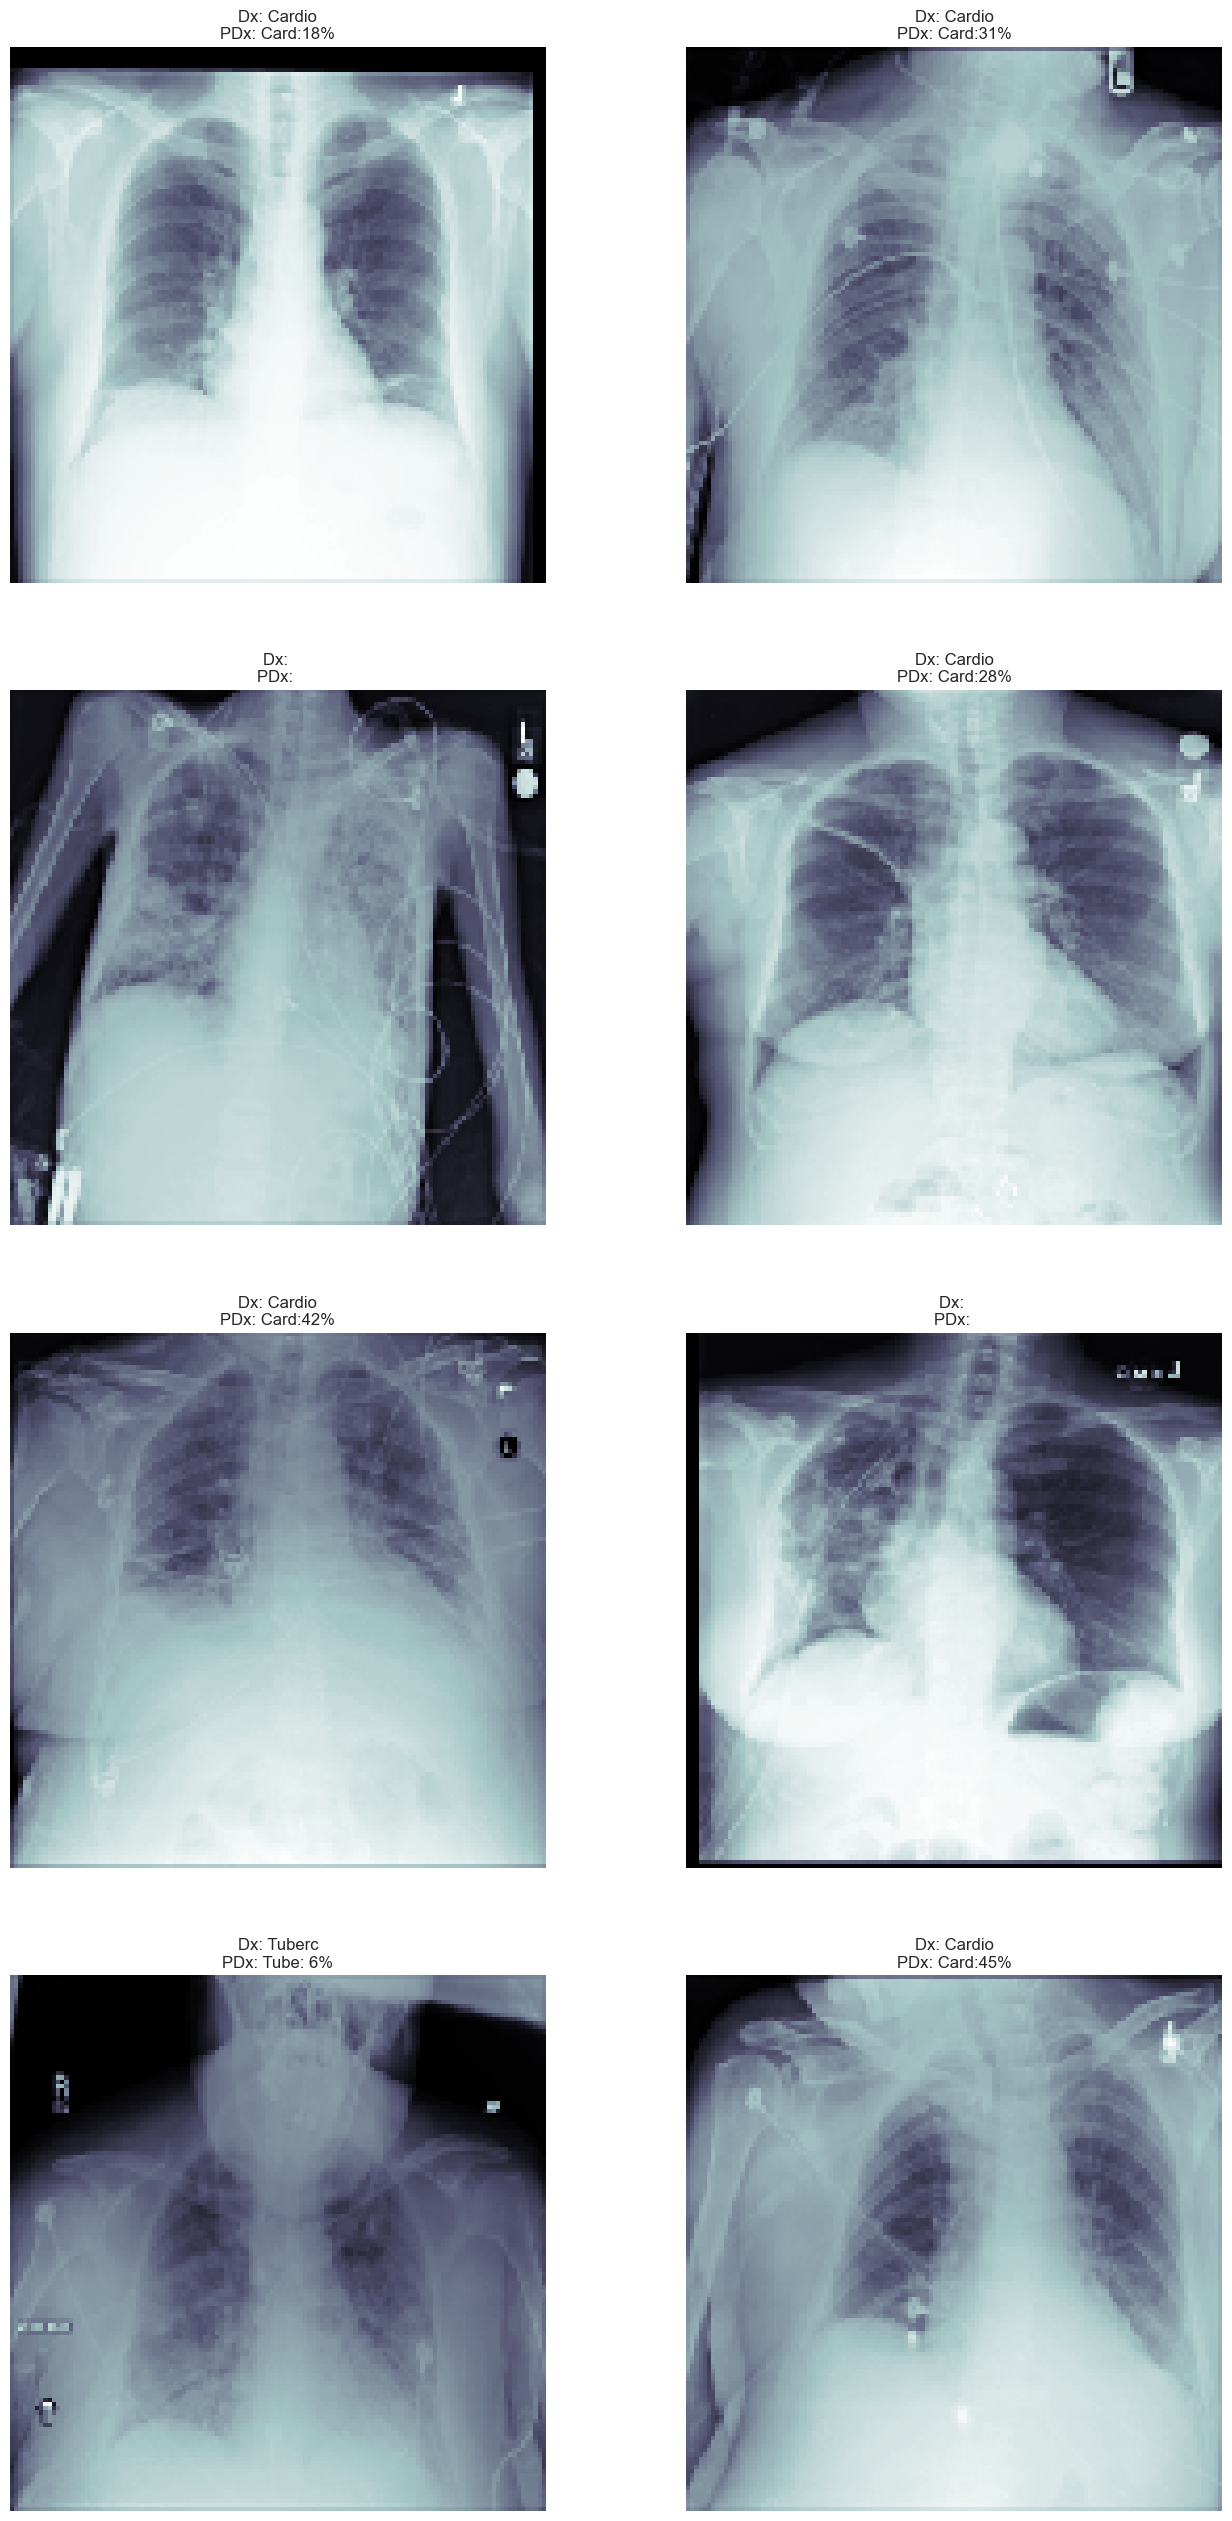

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')